In [1]:
import os
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {‘0’, ‘1’, ‘2’}
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_CPP_VMODULE"]="gpu_process_state=10,gpu_cudamallocasync_allocator=10"
#from tf_keras import layers, Model, models
from tensorflow.keras import layers, Model, models, metrics, optimizers
from sklearn.model_selection import train_test_split
#from tensorflow import keras
import keras
import keras.backend as K
import tensorflow_datasets as tfds
import datetime
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gc
import os
import json
tf.random.set_seed(1)

2024-11-26 18:25:58.575605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
Num GPUs Available:  0


# Data wrangling

In [3]:

# Load and align data
child_pheno_data = pd.read_csv("./data/pheno_data/pheno_tassel_dist.csv", 
                               index_col=["pop", "individual"])
child_mean = pd.read_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_mean_all_samples.csv",
                         index_col=["pop", "individual"]).reindex(child_pheno_data.index)
child_logvar = pd.read_csv("./data/var_autoencoder/with_unseen_children_vanilla_vae/encoded_logvar_all_samples.csv",
                           index_col=["pop", "individual"]).reindex(child_pheno_data.index)
parent_pheno_data = pd.read_csv("./data/pheno_data/parents_tassel.csv")

# Convert data to numpy arrays
child_mean_np = child_mean.to_numpy()[:, :-2]
child_logvar_np = child_logvar.to_numpy()[:, :-2]

# Extract and shuffle parent IDs
pop_per_sample = np.array([idx[0] for idx in child_pheno_data.index])
p_genos_ids = np.stack([child_mean["p1_id"].to_numpy(), child_mean["p2_id"].to_numpy()], axis=1)
np.apply_along_axis(np.random.shuffle, 1, p_genos_ids)

# Extract parent phenotypes
def extract_phenos(ids, parent_data):
    return np.array([parent_data.loc[parent_data["p_id"] == cur_id, ["mean_value", "sd_value"]].to_numpy().flatten()
                     for cur_id in ids])

p1_phenos = extract_phenos(p_genos_ids[:, 0], parent_pheno_data)
p2_phenos = extract_phenos(p_genos_ids[:, 1], parent_pheno_data)

# Extract child phenotypes
child_pheno_np = child_pheno_data[["val_mean", "val_sd"]].to_numpy()

# Stack phenotypes and genotypes
parents_phenos = np.stack([p1_phenos, p2_phenos], axis=1)
child_geno_dist = np.stack([child_mean_np, child_logvar_np], axis=1)


In [4]:
test_pops = np.random.choice(np.unique(pop_per_sample), 4)
train_pops_idx = ~np.isin(pop_per_sample, test_pops)

In [32]:
child_geno_dist_train = child_geno_dist[train_pops_idx, :]
parents_phenos_train = parents_phenos[train_pops_idx, :]
child_pheno_np_train = child_pheno_np[train_pops_idx, :]
child_geno_dist_dt_train = tf.data.Dataset.from_tensor_slices(child_geno_dist_train)
parents_phenos_dt_train = tf.data.Dataset.from_tensor_slices(parents_phenos_train)
input_data_train = tf.data.Dataset.zip(parents_phenos_dt_train, child_geno_dist_dt_train)
child_pheno_tensor_train = tf.data.Dataset.from_tensor_slices(child_pheno_np_train)
full_train_dataset = tf.data.Dataset.zip(input_data_train, child_pheno_tensor_train)
full_train_dataset = full_train_dataset.shuffle(buffer_size=parents_phenos_train.shape[0])
train_dataset = full_train_dataset.take(3000)
val_dataset = full_train_dataset.skip(3000)
train_dataset = train_dataset.batch(256, drop_remainder=True)
val_dataset = val_dataset.batch(256, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

child_pheno_np_test = child_pheno_np[~train_pops_idx, :]
child_geno_dist_test = child_geno_dist[~train_pops_idx, :]
parents_phenos_test = parents_phenos[~train_pops_idx, :]
child_geno_dist_dt_test = tf.data.Dataset.from_tensor_slices(child_geno_dist_test)
parents_phenos_dt_test = tf.data.Dataset.from_tensor_slices(parents_phenos_test)
input_data_test = tf.data.Dataset.zip(parents_phenos_dt_test, child_geno_dist_dt_test)
child_pheno_tensor_test = tf.data.Dataset.from_tensor_slices(child_pheno_np_test)
full_test_dataset = tf.data.Dataset.zip(input_data_test, child_pheno_tensor_test)
full_test_dataset = full_test_dataset.batch(child_pheno_np_test.shape[0])

In [36]:
print(child_geno_dist_test.shape)
print(parents_phenos_test.shape)
print(child_pheno_np_test.shape)

(387, 2, 100)
(387, 2, 2)
(387, 2)


In [35]:
print(child_geno_dist_train.shape)
print(parents_phenos_train.shape)
print(child_pheno_np_train.shape)

(4302, 2, 100)
(4302, 2, 2)
(4302, 2)


# Model definitions

In [49]:
def perc_error(y_true, y_pred):
    diff = tf.math.abs((y_true - y_pred)/y_true)
    n_samples = tf.cast(tf.shape(diff)[0], dtype=tf.float64)
    mean_per_f = tf.math.reduce_sum(diff, axis = 0)/n_samples
    return mean_per_f

def error_per_feature_mean(y_true, y_pred):
    return perc_error((tf.cast(y_true[:, 0], tf.float64)), tf.cast(y_pred[:, 0], tf.float64))

def error_per_feature_sd(y_true, y_pred):
    return perc_error((tf.cast(y_true[:, 1], tf.float64)), tf.cast(y_pred[:, 1], tf.float64))

def mean_y(y_true, y_pred):
    return tf.math.reduce_mean(y_pred)

def std_y(y_true, y_pred):
    return tf.math.reduce_std(y_pred)

@tf.function
def sample_z(mean, logvar):
    batch_size = tf.shape(mean)[0]  # Use dynamic shape inference for batch size
    latent_dim = mean.shape[1]      # Latent dimension can be known statically
    eps = tf.random.normal(shape=(batch_size, latent_dim))  # Use dynamic batch size
    res = eps * tf.exp(logvar * .5) + mean
    return res

@keras.saving.register_keras_serializable()
class sampling_layer(tf.keras.layers.Layer):
    def call(self, inputs, training=True):
        if training:
            return sample_z(inputs[:, 0, ...], inputs[:, 1, ...])
        return inputs

In [70]:
# Define the autoencoder model
fc_reg = keras.regularizers.L2(1e-4)
l_relu = layers.LeakyReLU(negative_slope=0.5)
@keras.saving.register_keras_serializable()
class trait_pred(Model):
    def __init__(self, width = 5, depth = 5, **kwargs):
        super().__init__(**kwargs)
        self.blocks = []
        self.depth = depth
        self.width = width
        self.sampling_layer = sampling_layer()

        for cur_sub_id in range(self.width):
            cur_sub_block = []
            
            for layer_id in range(self.depth, 1, -1):
                cur_sub_block.append(layers.Dense(units=(layer_id + 1) ** 4, activation=None))#, kernel_regularizer=fc_reg))#, kernel_regularizer=fc_reg))    
                cur_sub_block[len(cur_sub_block)-1].name = f"dense_{layer_id}_w_{cur_sub_id}"
                cur_sub_block.append(l_relu)
            
            cur_sub_block.append(layers.Dense(units = 6, activation=None, kernel_regularizer=fc_reg))
            cur_sub_block[len(cur_sub_block)-1].name = f"dense_final_w_{cur_sub_id}"
            cur_sub_block.append(l_relu)
            self.blocks.append(cur_sub_block)
        
    def get_config(self):
        config = super(trait_pred, self).get_config()
        config.update({
            'width': self.width,
            'depth': self.depth
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)  # Use variable arguments to simplify reconstructing the object
    
    def call(self, x):
        parent_phenos_pre = x[0]
        x_geno = x[1]
        x = self.sampling_layer(x_geno)
        outputs = []
        for cur_block in self.blocks:
            sub_x = x
            for cur_layer in cur_block:
                sub_x = cur_layer(sub_x)
            outputs.append(sub_x)
        raw_weights = tf.math.reduce_sum(outputs, axis = 0)
        # Use dynamic reshaping
        batch_size = tf.shape(parent_phenos_pre)[0]
        num_parent_phenos = tf.shape(parent_phenos_pre)[1]
        weights = tf.reshape(raw_weights, (batch_size, num_parent_phenos, -1))
        
        scaling_weights = weights[..., :2]
        bias = weights[..., 2:]
        bias = tf.reshape(bias, (batch_size, -1))
        scaled_parents = scaling_weights * parent_phenos_pre
        y = tf.reduce_sum(scaled_parents, axis=1) + bias
        return [y, scaling_weights, bias]

# Grid testing

In [ ]:
def fit_per_para(depth, width, epochs = 100):
    print("###########################################")
    print(f"depth: {depth}")
    print(f"width: {width}")
    trait_loss = tf.keras.losses.MAE
    trait_optimizer = optimizers.Adam(learning_rate=1e-4, use_ema = True, gradient_accumulation_steps = 10)# ema_overwrite_frequency = int(1e3))
    trait_model = trait_pred(depth=depth, width=width)
    trait_model.compile(optimizer=trait_optimizer, loss = trait_loss, run_eagerly=False,
                  metrics=[error_per_feature_mean, error_per_feature_sd])
    model_train_loss = trait_model.fit(x=geno_tensor, y=pheno_tensor, epochs=epochs, shuffle=True,
              batch_size = 32, validation_split = 0.3)
    del trait_model
    gc.collect()
    tf.keras.backend.clear_session()
    gc.collect()

    return model_train_loss

In [ ]:
paras = list(itertools.product(list(range(5,0,-1)),list(range(5,0, -1))))
#paras = list(itertools.product([5],list(range(1,5)))) + list(itertools.product(list(range(1,5)),[5])) + [(5,5)]
# paras_l = list(itertools.product(list(range(10,5, -1)), list(range(10,0, -1)))) + list(itertools.product(list(range(5,0, -1)), list(range(10,5, -1))))

In [ ]:
res_per_para = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 50) for cur_paras in paras]
#res_per_paral = [fit_per_para(cur_paras[0], cur_paras[1], epochs = 200) for cur_paras in paras]

In [ ]:
res_dict = {str(paras[cur_para_id]):[res_per_para[cur_para_id].history] for cur_para_id in range(len(paras))}
res_out = open("geno_to_trait_5.txt", "w")
res_out.write(json.dumps(res_dict))
res_out.close()

In [ ]:
res_deep_encoder_thining = json.loads(open("./geno_to_trait_5.txt").read())

In [ ]:
res_deep_encoder_thining
dt_keys = list(res_deep_encoder_thining.keys())

In [ ]:
res_deep_encoder_thining = json.loads(open("./geno_to_trait_5.txt").read())
dt_keys = list(res_deep_encoder_thining.keys())
dt_mean_error = np.array([res_deep_encoder_thining[cur_dict][0]["error_per_feature_mean"] for cur_dict in dt_keys])
dt_mean_error_df = pd.DataFrame(dt_mean_error)
dt_mean_error_df["fit"] = dt_keys
dt_mean_error_df.to_csv("./data/dt_mean_error_df_5.csv")
dt_sd_error = np.array([res_deep_encoder_thining[cur_dict][0]["error_per_feature_sd"] for cur_dict in dt_keys])
dt_sd_error_df = pd.DataFrame(dt_sd_error)
dt_sd_error_df["fit"] = dt_keys
dt_sd_error_df.to_csv("./data/dt_sd_error_df_5.csv")
dt_loss = np.array([res_deep_encoder_thining[cur_dict][0]["loss"] for cur_dict in dt_keys])
dt_loss_df = pd.DataFrame(dt_loss)
dt_loss_df["fit"] = dt_keys
dt_loss_df.to_csv("./data/dt_loss_df_5.csv")
dt_mean_error_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_error_per_feature_mean"] for cur_dict in dt_keys])
dt_mean_error_val_df = pd.DataFrame(dt_mean_error_val)
dt_mean_error_val_df["fit"] = dt_keys
dt_mean_error_val_df.to_csv("./data/dt_mean_error_val_df_5.csv")
dt_sd_error_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_error_per_feature_sd"] for cur_dict in dt_keys])
dt_sd_error_val_df = pd.DataFrame(dt_sd_error_val)
dt_sd_error_val_df["fit"] = dt_keys
dt_sd_error_val_df.to_csv("./data/dt_sd_error_val_df_5.csv")
dt_loss_val = np.array([res_deep_encoder_thining[cur_dict][0]["val_loss"] for cur_dict in dt_keys])
dt_loss_val_df = pd.DataFrame(dt_loss_val)
dt_loss_val_df["fit"] = dt_keys
dt_loss_val_df.to_csv("./data/dt_loss_val_df_5.csv")

# Individual models

#### Model Training

In [54]:
trait_loss = tf.keras.losses.MeanAbsolutePercentageError()
trait_optimizer = optimizers.Lion(learning_rate=5e-5)#, use_ema = True, gradient_accumulation_steps = 10)#, ema_overwrite_frequency = int(1e3))# ema_overwrite_frequency = int(1e3))
trait_model = trait_pred(5,5)
trait_model.compile(optimizer=trait_optimizer, loss = trait_loss, run_eagerly=False,
                  metrics=[error_per_feature_mean, error_per_feature_sd, mean_y, std_y])#, error_per_feature_sd])
# cur_sample_range = 4689

In [55]:
model_train_loss = trait_model.fit(train_dataset, epochs=3000, shuffle=True,
                                    validation_data = full_test_dataset)#, validation_split = 0.3

Epoch 1/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - error_per_feature_mean: 0.7705 - error_per_feature_sd: 0.7034 - loss: 73.6979 - mean_y: 37.7829 - std_y: 52.2180 - val_error_per_feature_mean: 0.7244 - val_error_per_feature_sd: 0.4198 - val_loss: 57.2175 - val_mean_y: 66.2013 - val_std_y: 66.2355
Epoch 2/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - error_per_feature_mean: 0.6932 - error_per_feature_sd: 0.4648 - loss: 57.9055 - mean_y: 49.1938 - std_y: 51.0705 - val_error_per_feature_mean: 0.6276 - val_error_per_feature_sd: 0.4825 - val_loss: 55.5109 - val_mean_y: 20.6895 - val_std_y: 20.4280
Epoch 3/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - error_per_feature_mean: 0.6009 - error_per_feature_sd: 0.4581 - loss: 52.9560 - mean_y: 40.3141 - std_y: 40.1012 - val_error_per_feature_mean: 0.6089 - val_error_per_feature_sd: 0.3201 - val_loss: 46.4553 - val_mean_y: 63.0857 - val_std_y: 59.5366
Epoch 4/3000
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - error_per_feature_mean: 0.6339 - er

min val loss at epoch 2862, with loss 9.862915992736816


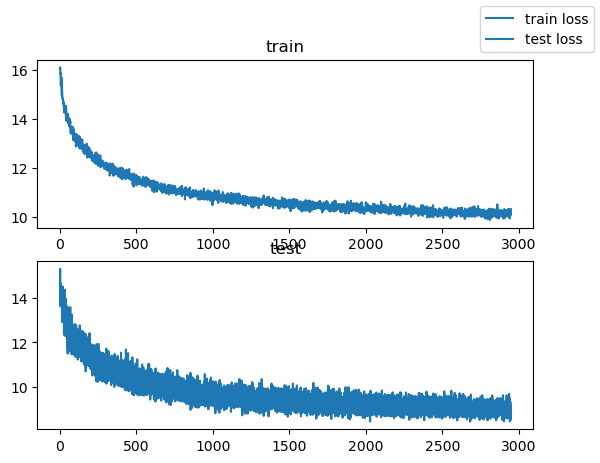

In [56]:
# 4.8272, Adam
# 2.9391, Lion
    # 2.3782, 1000 E
print(f"min val loss at epoch {np.argmin(model_train_loss.history["loss"])}, with loss {np.min(model_train_loss.history["loss"])}")
fig, ax = plt.subplots(2, 1)
x = list(range(len(model_train_loss.history["loss"][50:])))
ax[0].plot(x, model_train_loss.history["loss"][50:], label = "train loss")
ax[0].set_title("train")
ax[1].plot(x, model_train_loss.history["val_loss"][50:], label = "test loss")
ax[1].set_title("test")
fig.legend()

In [57]:
trait_model.save("geno_to_trait_para_per_parent.keras")

In [71]:
rec_trait_model = keras.models.load_model(
    "geno_to_trait_para_per_parent.keras",
    custom_objects = {"error_per_feature_mean" : error_per_feature_mean,
                      "error_per_feature_sd" : error_per_feature_sd,
                      "mean_y" : mean_y, "std_y" : mean_y}
)

In [72]:
cur_model = rec_trait_model

# Feature Importance

In [66]:
test_batch_geno_dist = []
test_batch_p_phenos = []
test_batch_c_phenos = []
for batch in full_test_dataset:
    geno_dist, phenos = batch
    test_batch_geno_dist.append(geno_dist[1])
    test_batch_p_phenos.append(geno_dist[0])
    test_batch_c_phenos.append(phenos)
test_genos_dist_np = np.concatenate(test_batch_geno_dist)
test_p_phenos_np = np.concatenate(test_batch_p_phenos)
test_labels_tensor = np.concatenate(test_batch_c_phenos)

train_batch_geno_dist = []
train_batch_p_phenos = []
train_batch_c_phenos = []
for batch in train_dataset:
    geno_dist, phenos = batch
    train_batch_geno_dist.append(geno_dist[1])
    train_batch_p_phenos.append(geno_dist[0])
    train_batch_c_phenos.append(phenos)
train_genos_dist_np = np.concatenate(train_batch_geno_dist)
train_p_phenos_np = np.concatenate(train_batch_p_phenos)
train_labels_tensor = np.concatenate(train_batch_c_phenos)

val_batch_geno_dist = []
val_batch_p_phenos = []
val_batch_c_phenos = []
for batch in val_dataset:
    geno_dist, phenos = batch
    val_batch_geno_dist.append(geno_dist[1])
    val_batch_p_phenos.append(geno_dist[0])
    val_batch_c_phenos.append(phenos)
val_genos_dist_np = np.concatenate(val_batch_geno_dist)
val_p_phenos_np = np.concatenate(val_batch_p_phenos)
val_labels_tensor = np.concatenate(val_batch_c_phenos)


2024-11-26 21:24:13.789543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-26 21:24:13.819848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-26 21:24:13.853774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#rand_geno_data = ordered_geno_data.iloc[:, 1:-1].to_numpy()
mean_error = []
sd_error = []
rand_mean = copy.deepcopy(test_genos_dist_np[:, 0, ...])
rand_logvar = copy.deepcopy(test_genos_dist_np[:, 1, ...])
rand_p_phenos = copy.deepcopy(test_p_phenos_np)
for feature_id in np.arange(child_mean_np.shape[1]):
    
    
    
    np.random.shuffle(rand_mean[:, feature_id])
    np.random.shuffle(rand_logvar[:, feature_id])
    rand_geno_dist = np.stack([rand_mean, rand_logvar], axis = 1)
    rand_pred = cur_model((test_p_phenos_np, rand_geno_dist))
    cur_mean_error = error_per_feature_mean(rand_pred, test_labels_tensor)
    mean_error.append(cur_mean_error)
    print(f"Feature {feature_id} mean error: {cur_mean_error}")
    cur_sd_error = error_per_feature_sd(rand_pred, test_labels_tensor)
    sd_error.append(cur_sd_error)
    print(f"Feature {feature_id} sd error: {cur_sd_error}")

In [132]:
normal_mean_error = error_per_feature_mean(cur_model((test_p_phenos_np, test_genos_dist_np)), test_labels_tensor)
normal_sd_error = error_per_feature_sd(cur_model((test_p_phenos_np, test_genos_dist_np)), test_labels_tensor)
mean_error_diff = mean_error-normal_mean_error
sd_error_diff = sd_error-normal_sd_error

pd_error_dict = {"mean_error": mean_error_diff, "sd_error":sd_error_diff}
pd_error_df = pd.DataFrame(pd_error_dict)
pd_error_df.to_csv("./data/geno_to_trait/feature_importance/error_per_feature_inc.csv")

In [109]:
test_pred = cur_model((test_p_phenos_np, test_genos_dist_np))[0].numpy()
test_pred_df = pd.DataFrame(test_pred, columns=["pred_mean", "pred_sd"])#.to_csv("./data/geno_to_trait/test_predictions.csv", index = False)
test_pred_df["data_type"] = "test_pred"
val_pred = cur_model((val_p_phenos_np, val_genos_dist_np))[0]
val_pred_df = pd.DataFrame(val_pred, columns=["pred_mean", "pred_sd"])#.to_csv("./data/geno_to_trait/val_predictions.csv", index = False)
val_pred_df["data_type"] = "val_pred"
train_pred = cur_model((train_p_phenos_np, train_genos_dist_np))[0]
train_pred_df = pd.DataFrame(train_pred, columns=["pred_mean", "pred_sd"])#.to_csv("./data/geno_to_trait/train_predictions.csv", index = False)
train_pred_df["data_type"] = "train_pred"


test_truth_df = pd.DataFrame(test_labels_tensor, columns = ["actual_mean", "actual_sd"])
test_truth_df["data_type"] = "test_pred"

val_truth_df = pd.DataFrame(val_labels_tensor, columns=["actual_mean", "actual_sd"])
val_truth_df["data_type"] = "val_pred"

train_truth_df = pd.DataFrame(train_labels_tensor, columns=["actual_mean", "actual_sd"])
train_truth_df["data_type"] = "train_pred"

pred_df = pd.concat([val_pred_df, test_pred_df, train_pred_df], axis = 0)
full_res_df = pd.concat([pred_df,
    pd.concat([val_truth_df, test_truth_df, train_truth_df], axis = 0)],
    axis = 1)
full_res_df.to_csv("./data/geno_to_trait/oop_predictions_eval.csv", index = False)

# Model analysis

In [82]:
test_y = cur_model((test_p_phenos_np, test_genos_dist_np))[1]

In [97]:
test_pred = cur_model((test_p_phenos_np, test_genos_dist_np))
test_pred_w = test_pred[1].numpy().reshape((test_pred[1].shape[0], -1))
test_pred_b = test_pred[2].numpy().reshape((test_pred[2].shape[0], -1))
test_pred_p = np.concatenate([test_pred_w, test_pred_b], axis = 1)
val_pred = cur_model((val_p_phenos_np, val_genos_dist_np))
val_pred_w = val_pred[1].numpy().reshape((val_pred[1].shape[0], -1))
val_pred_b = val_pred[2].numpy().reshape((val_pred[2].shape[0], -1))
val_pred_p = np.concatenate([val_pred_w, val_pred_b], axis = 1)
train_pred = cur_model((train_p_phenos_np, train_genos_dist_np))
train_pred_w = train_pred[1].numpy().reshape((train_pred[1].shape[0], -1))
train_pred_b = train_pred[2].numpy().reshape((train_pred[2].shape[0], -1))
train_pred_p = np.concatenate([train_pred_w, train_pred_b], axis = 1)

test_p_df = pd.DataFrame(test_pred_p,
    columns = ["p1_mean_weights", "p1_sd_weights", "p2_mean_weights", "p2_sd_weights", "mean_bias", "sd_bias"])
test_p_df["data_type"] = "test_pred"

val_p_df = pd.DataFrame(val_pred_p, columns = ["p1_mean_weights", "p1_sd_weights", "p2_mean_weights", "p2_sd_weights", "mean_bias", "sd_bias"])
val_p_df["data_type"] = "val_pred"

train_p_df = pd.DataFrame(train_pred_p, columns = ["p1_mean_weights", "p1_sd_weights", "p2_mean_weights", "p2_sd_weights", "mean_bias", "sd_bias"])
train_p_df["data_type"] = "train_pred"

para_df = pd.concat([test_p_df, val_p_df, train_p_df], axis = 0)
para_df.to_csv("./data/geno_to_trait/sample_pheno_weights_per_dtype.csv", index = False)

In [107]:
full_pred = cur_model((parents_phenos, child_geno_dist))
full_pred_w = full_pred[1].numpy().reshape((full_pred[1].shape[0], -1))
full_pred_b = full_pred[2].numpy().reshape((full_pred[2].shape[0], -1))
full_pred_p = np.concatenate([full_pred_w, full_pred_b], axis = 1)

full_pred_df = pd.DataFrame(full_pred_p, columns = ["p1_mean_weights", "p1_sd_weights", "p2_mean_weights", "p2_sd_weights", "mean_bias", "sd_bias"])
full_pred_df["pop"] = pop_per_sample
full_pred_df["p1_id"] = child_mean["p1_id"].to_numpy()
full_pred_df["p2_id"] = child_mean["p2_id"].to_numpy()

full_pred_df.to_csv("./data/geno_to_trait/sample_pheno_weights_per_pop.csv", index = False)